In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
import numpy as np
import time


In [7]:

# --- 1. Setup and Data Loading ---

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)

# Set device to GPU (cuda) if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for the data
# We normalize the data using the mean and std dev of the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10

# --- 2. Model 1: CNN from Scratch ---

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Same architecture as the Keras model
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

# --- 3. Model 2: Simple Neural Network (MLP) Baseline ---

class MLPBaseline(nn.Module):
    def __init__(self):
        super(MLPBaseline, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

# --- 4. Model 3: Transfer Learning (VGG16) Baseline ---

def create_transfer_learning_model():
    # Load pre-trained VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    
    # Freeze all the layers in the feature extractor
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Replace the classifier with a new one for CIFAR-10
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model

# --- 5. Training and Evaluation Functions ---

def train_model(model, trainloader, criterion, optimizer, epochs=EPOCHS):
    """Function to train the model."""
    model.to(device)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        
        # Evaluate on test set
        val_loss, val_acc = evaluate_model(model, testloader, criterion)
        
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc / 100.0) # Scale accuracy to 0-1 for plotting
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epochs} | Time: {end_time - start_time:.2f}s | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
    print('Finished Training')
    return history


def evaluate_model(model, testloader, criterion):
    """Function to evaluate the model."""
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# --- 6. Instantiate, Train, and Evaluate Models ---

# Loss function
criterion = nn.CrossEntropyLoss()


PyTorch Version: 2.5.1+cu121
Torchvision Version: 0.20.1+cu121
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [5]:

# --- CNN from Scratch ---
print("\n--- Training CNN from Scratch ---")
cnn_model = CustomCNN()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
history_cnn = train_model(cnn_model, trainloader, criterion, optimizer_cnn, epochs=EPOCHS)
final_loss_cnn, final_acc_cnn = evaluate_model(cnn_model, testloader, criterion)



--- Training CNN from Scratch ---
Epoch 1/10 | Time: 7.15s | Loss: 1.5369 | Acc: 43.85% | Val Loss: 1.1792 | Val Acc: 57.89%
Epoch 2/10 | Time: 8.24s | Loss: 1.1675 | Acc: 58.76% | Val Loss: 1.0162 | Val Acc: 64.38%
Epoch 3/10 | Time: 8.54s | Loss: 0.9921 | Acc: 65.42% | Val Loss: 0.8764 | Val Acc: 69.53%
Epoch 4/10 | Time: 8.44s | Loss: 0.8722 | Acc: 69.80% | Val Loss: 0.8260 | Val Acc: 72.03%
Epoch 5/10 | Time: 7.76s | Loss: 0.7937 | Acc: 72.64% | Val Loss: 0.7470 | Val Acc: 74.06%
Epoch 6/10 | Time: 8.47s | Loss: 0.7240 | Acc: 74.62% | Val Loss: 0.7827 | Val Acc: 73.30%
Epoch 7/10 | Time: 8.82s | Loss: 0.6749 | Acc: 76.55% | Val Loss: 0.7122 | Val Acc: 75.71%
Epoch 8/10 | Time: 9.77s | Loss: 0.6244 | Acc: 78.05% | Val Loss: 0.7314 | Val Acc: 75.67%
Epoch 9/10 | Time: 16.43s | Loss: 0.5911 | Acc: 79.37% | Val Loss: 0.7180 | Val Acc: 76.02%
Epoch 10/10 | Time: 11.43s | Loss: 0.5520 | Acc: 80.66% | Val Loss: 0.7254 | Val Acc: 76.40%
Finished Training


In [6]:

# --- MLP Baseline ---
print("\n--- Training MLP Baseline ---")
mlp_model = MLPBaseline()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
history_mlp = train_model(mlp_model, trainloader, criterion, optimizer_mlp, epochs=EPOCHS)
final_loss_mlp, final_acc_mlp = evaluate_model(mlp_model, testloader, criterion)



--- Training MLP Baseline ---
Epoch 1/10 | Time: 11.88s | Loss: 1.7007 | Acc: 39.81% | Val Loss: 1.5447 | Val Acc: 45.87%
Epoch 2/10 | Time: 14.37s | Loss: 1.5308 | Acc: 46.00% | Val Loss: 1.4764 | Val Acc: 47.49%
Epoch 3/10 | Time: 14.81s | Loss: 1.4543 | Acc: 48.69% | Val Loss: 1.4596 | Val Acc: 48.80%
Epoch 4/10 | Time: 15.62s | Loss: 1.3976 | Acc: 50.52% | Val Loss: 1.4301 | Val Acc: 49.51%
Epoch 5/10 | Time: 8.70s | Loss: 1.3476 | Acc: 52.21% | Val Loss: 1.3976 | Val Acc: 50.51%
Epoch 6/10 | Time: 12.23s | Loss: 1.3052 | Acc: 53.88% | Val Loss: 1.3839 | Val Acc: 51.49%
Epoch 7/10 | Time: 14.62s | Loss: 1.2645 | Acc: 55.29% | Val Loss: 1.3828 | Val Acc: 51.77%
Epoch 8/10 | Time: 16.81s | Loss: 1.2291 | Acc: 56.58% | Val Loss: 1.3792 | Val Acc: 52.15%
Epoch 9/10 | Time: 16.97s | Loss: 1.2001 | Acc: 57.66% | Val Loss: 1.4286 | Val Acc: 50.44%
Epoch 10/10 | Time: 17.05s | Loss: 1.1667 | Acc: 58.71% | Val Loss: 1.4087 | Val Acc: 51.38%
Finished Training


In [7]:

# --- Transfer Learning Model ---
LEARNING_RATE = 0.001  # Assuming this is your rate for models from scratch
EPOCHS = 10

# Add a much smaller learning rate for fine-tuning
LEARNING_RATE_TRANSFER = 0.0001
print("\n--- Training Transfer Learning (VGG16) Baseline ---")
# --- Transfer Learning Model ---
print("\n--- Training Transfer Learning (VGG16) Baseline ---")
transfer_model = create_transfer_learning_model()

# Use the new, smaller learning rate here
optimizer_transfer = optim.Adam(transfer_model.classifier.parameters(), 
                                lr=LEARNING_RATE_TRANSFER) 

history_transfer = train_model(transfer_model, trainloader, criterion, optimizer_transfer, epochs=EPOCHS)
final_loss_transfer, final_acc_transfer = evaluate_model(transfer_model, testloader, criterion)



--- Training Transfer Learning (VGG16) Baseline ---

--- Training Transfer Learning (VGG16) Baseline ---
Epoch 1/10 | Time: 19.12s | Loss: 1.1351 | Acc: 61.01% | Val Loss: 0.9523 | Val Acc: 66.62%
Epoch 2/10 | Time: 18.63s | Loss: 0.9959 | Acc: 65.70% | Val Loss: 0.9244 | Val Acc: 68.07%
Epoch 3/10 | Time: 18.89s | Loss: 0.9479 | Acc: 67.10% | Val Loss: 0.9065 | Val Acc: 68.54%
Epoch 4/10 | Time: 18.55s | Loss: 0.9020 | Acc: 68.55% | Val Loss: 0.9065 | Val Acc: 68.37%
Epoch 5/10 | Time: 18.12s | Loss: 0.8686 | Acc: 69.75% | Val Loss: 0.9034 | Val Acc: 69.06%
Epoch 6/10 | Time: 18.94s | Loss: 0.8413 | Acc: 70.25% | Val Loss: 0.8964 | Val Acc: 68.93%
Epoch 7/10 | Time: 19.28s | Loss: 0.8191 | Acc: 71.14% | Val Loss: 0.9046 | Val Acc: 68.65%
Epoch 8/10 | Time: 18.42s | Loss: 0.7948 | Acc: 71.84% | Val Loss: 0.8932 | Val Acc: 69.31%
Epoch 9/10 | Time: 18.77s | Loss: 0.7741 | Acc: 72.41% | Val Loss: 0.9094 | Val Acc: 69.28%
Epoch 10/10 | Time: 19.22s | Loss: 0.7550 | Acc: 73.03% | Val Loss


--- Final Model Evaluation ---
CNN from Scratch       - Test Accuracy: 76.40%
MLP Baseline           - Test Accuracy: 51.38%
Transfer Learning (VGG16) - Test Accuracy: 69.00%


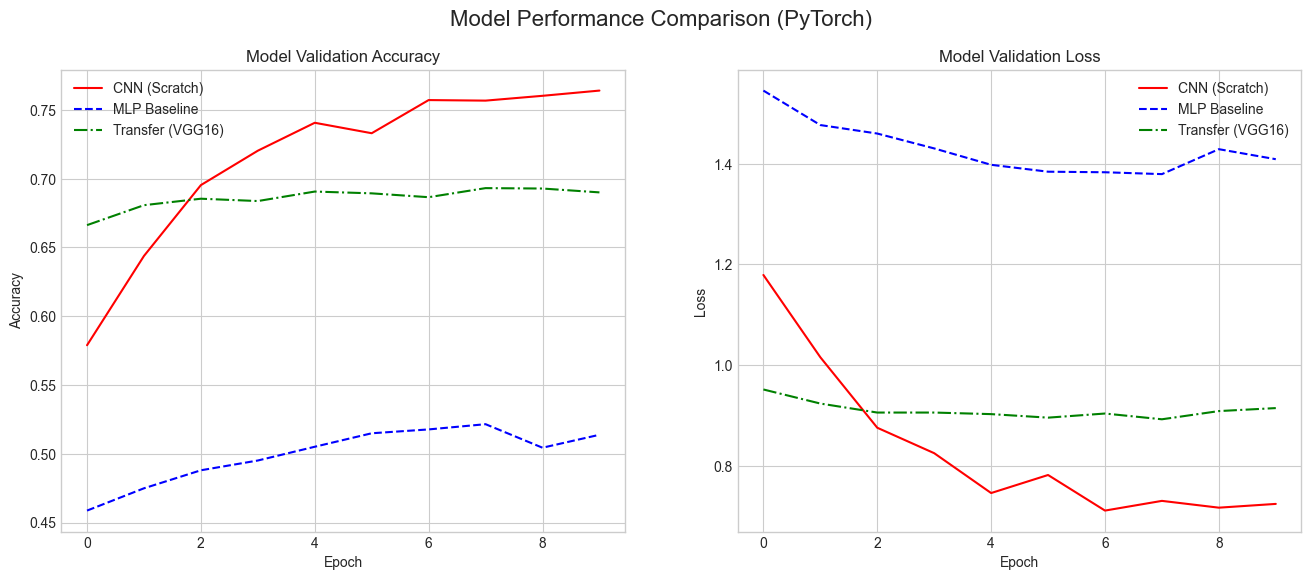

In [8]:

# --- 7. Final Results and Comparison ---

print("\n--- Final Model Evaluation ---")
print(f"CNN from Scratch       - Test Accuracy: {final_acc_cnn:.2f}%")
print(f"MLP Baseline           - Test Accuracy: {final_acc_mlp:.2f}%")
print(f"Transfer Learning (VGG16) - Test Accuracy: {final_acc_transfer:.2f}%")

# --- Plotting the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 6))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn['val_accuracy'], label='CNN (Scratch)', color='red', linestyle='-')
plt.plot(history_mlp['val_accuracy'], label='MLP Baseline', color='blue', linestyle='--')
plt.plot(history_transfer['val_accuracy'], label='Transfer (VGG16)', color='green', linestyle='-.')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn['val_loss'], label='CNN (Scratch)', color='red', linestyle='-')
plt.plot(history_mlp['val_loss'], label='MLP Baseline', color='blue', linestyle='--')
plt.plot(history_transfer['val_loss'], label='Transfer (VGG16)', color='green', linestyle='-.')
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.suptitle('Model Performance Comparison (PyTorch)', fontsize=16)
plt.show()

In [2]:
# --- 4. Model 3: Transfer Learning (ResNet18) Baseline ---
from torchvision.models import resnet18, ResNet18_Weights

def create_transfer_learning_model_resnet():
    """Builds a model using the pre-trained ResNet18 base."""
    # Load pre-trained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze all the layers in the feature extractor
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace the final fully connected layer (the classifier)
    # ResNet's classifier is a single layer called 'fc'
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

In [8]:
# --- Training Transfer Learning Model ---
print("\n--- Training Transfer Learning (ResNet18) Baseline ---")
# Call the new function
transfer_model = create_transfer_learning_model_resnet() 
# IMPORTANT: Only train the parameters of the new final layer
optimizer_transfer = optim.Adam(transfer_model.fc.parameters(), lr=LEARNING_RATE) 
# The rest of the code stays the same
history_transfer = train_model(transfer_model, trainloader, criterion, optimizer_transfer, epochs=EPOCHS)
final_loss_transfer, final_acc_transfer = evaluate_model(transfer_model, testloader,criterion)


--- Training Transfer Learning (ResNet18) Baseline ---
Epoch 1/10 | Time: 10.11s | Loss: 1.7323 | Acc: 39.61% | Val Loss: 1.6303 | Val Acc: 43.59%
Epoch 2/10 | Time: 19.02s | Loss: 1.5943 | Acc: 44.31% | Val Loss: 1.5979 | Val Acc: 44.33%
Epoch 3/10 | Time: 19.98s | Loss: 1.5859 | Acc: 44.61% | Val Loss: 1.5892 | Val Acc: 45.28%
Epoch 4/10 | Time: 19.81s | Loss: 1.5699 | Acc: 45.20% | Val Loss: 1.5946 | Val Acc: 45.01%
Epoch 5/10 | Time: 11.47s | Loss: 1.5652 | Acc: 45.59% | Val Loss: 1.5768 | Val Acc: 45.86%
Epoch 6/10 | Time: 16.61s | Loss: 1.5691 | Acc: 45.42% | Val Loss: 1.6161 | Val Acc: 44.02%
Epoch 7/10 | Time: 19.44s | Loss: 1.5646 | Acc: 45.54% | Val Loss: 1.5672 | Val Acc: 46.28%
Epoch 8/10 | Time: 19.72s | Loss: 1.5631 | Acc: 45.78% | Val Loss: 1.5610 | Val Acc: 46.18%
Epoch 9/10 | Time: 20.24s | Loss: 1.5637 | Acc: 45.41% | Val Loss: 1.5720 | Val Acc: 46.01%
Epoch 10/10 | Time: 19.05s | Loss: 1.5626 | Acc: 45.63% | Val Loss: 1.5765 | Val Acc: 46.06%
Finished Training
